# ARIMA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler

In [2]:
def graph_prediction(labels, predictions, data_index, plot_error=0, width=20, height=7):
    plt.figure(figsize=(width, height))
    line1, = plt.plot(data_index, labels, label='True Power Usage', color='blue', linewidth=1.5, alpha=0.7)
    line2, = plt.plot(data_index, predictions, label='Predicted Power Usage', color='orange', linewidth=1.5, alpha=0.7)
    if (plot_error):
        absolute_error = np.abs(labels - predictions)
        line3, = plt.plot(data_index, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1)
        plt.legend(handles=[line1, line2, line3], fontsize=12, loc='upper right')
        plt.title('Test Set Predictions vs True Values', fontsize=16)
        plt.xlabel('Datetime', fontsize=14)
        plt.ylabel('Hourly Active Power', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        plt.legend(handles=[line1, line2], fontsize=12, loc='upper right')
        plt.title('Test Set Predictions vs True Values', fontsize=16)
        plt.xlabel('Datetime', fontsize=14)
        plt.ylabel('Hourly Active Power', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def arima_order(data, lags):
    # Plot PACF - p
    plt.figure(figsize=(10, 6))
    plot_pacf(data, lags=lags)
    plt.ylim(-0.25, 1.5)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()

    # Check Stationary - d
    # Augmented Dickey-Fuller test for stationarity
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The process is stationary.")
    else:
        print("The process is not stationary.")

    # Plot ACF - q
    plt.figure(figsize=(10, 6))
    plot_acf(data, lags=lags)
    plt.ylim(-0.25, 1.5)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

In [3]:
# Load data
df = pd.read_csv('2yrs_data.csv')

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract datetime features
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year

# Aggregate data to hourly sums
df_hourly = df.groupby(['Year', 'Month', 'Day', 'Hour']).agg({'Global_active_power': 'sum'}).reset_index()

# Create 'DateTime' column from 'Year','Month','Day','Hour'
df_hourly['DateTime'] = pd.to_datetime(df_hourly[['Year', 'Month', 'Day', 'Hour']])

# Set 'DateTime' as index
df_hourly = df_hourly.set_index('DateTime')

# Scale 'Global_active_power'
scaler = StandardScaler()
df_hourly['hourly_active_power'] = scaler.fit_transform(df_hourly[['Global_active_power']])

# Drop unnecessary columns
df_hourly = df_hourly.drop(columns=['Global_active_power', 'Year', 'Month', 'Day', 'Hour'])

# Split data into train and test sets
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test = df_hourly.iloc[train_size:]

# Forward fill missing data (if any)
train = train.reindex(pd.date_range(start=train.index.min(), end=train.index.max(), freq='h'))
train = train.ffill()
test = test.reindex(pd.date_range(start=test.index.min(), end=test.index.max(), freq='h'))
test = test.ffill()

y_train = train['hourly_active_power']
y_test = test['hourly_active_power']

<Figure size 1000x600 with 0 Axes>

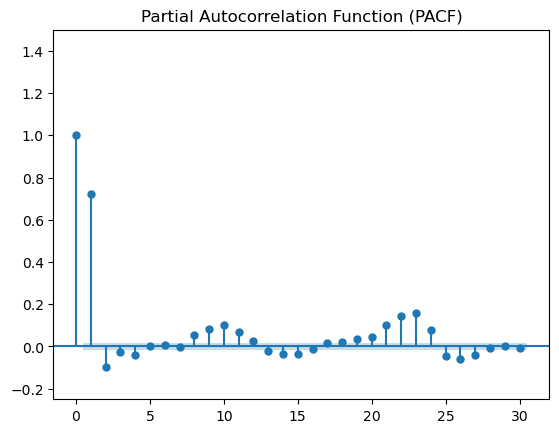

ADF Statistic: -12.001329493633243
p-value: 3.341240052097787e-22
The process is stationary.


<Figure size 1000x600 with 0 Axes>

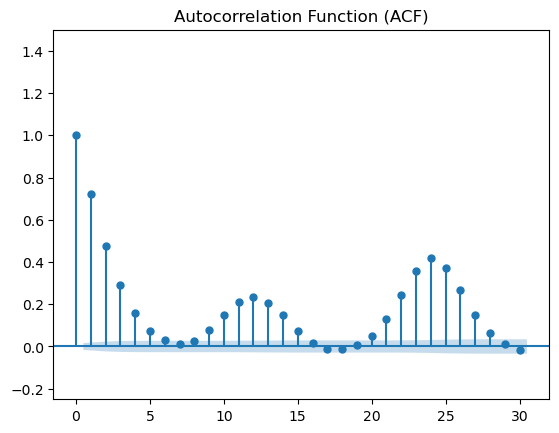

In [4]:
arima_order(y_train, 30)

In [5]:
y_train

2006-12-16 17:00:00    1.473913
2006-12-16 18:00:00    2.611597
2006-12-16 19:00:00    2.371349
2006-12-16 20:00:00    2.234981
2006-12-16 21:00:00    2.015309
                         ...   
2008-08-05 01:00:00   -0.766447
2008-08-05 02:00:00   -0.820165
2008-08-05 03:00:00   -0.840189
2008-08-05 04:00:00   -0.827691
2008-08-05 05:00:00   -0.861317
Freq: h, Name: hourly_active_power, Length: 14341, dtype: float64

In [6]:
y_train_one_month = y_train['2007-01-01 00:00:00':'2007-01-31 23:00:00']

results_seasonality = {}

for s in range(24,(24*7+1),24):
    model = ARIMA(y_train_one_month, order=(1, 0, 1), seasonal_order=(1,1,1,s))
    model_fit = model.fit()

    # Forecast values
    n_periods = len(y_test)
    forecast = model_fit.forecast(steps=n_periods)

    # Convert forecast to pandas Series
    forecast_series = pd.Series(forecast, index=y_test.index)

    # Evaluate the forecast against y_test on scaled data
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    mae = mean_absolute_error(y_test, forecast)
    r2 = r2_score(y_test, forecast)

    results_seasonality[s] = [rmse, mae, r2]

print(results_seasonality)

/Users/annizheng/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


{24: [1.3841813478953733, 1.1707159366924769, -1.1212249202594533], 48: [1.379959472489495, 1.1632673962014166, -1.108304807256209], 72: [1.3804831002623272, 1.1642599105568063, -1.1099051099081025], 96: [1.4092719815747836, 1.1763203776754652, -1.1988235021958138], 120: [1.4121285742854117, 1.1885608421242624, -1.2077465620531016], 144: [1.410853594221899, 1.1814633569723683, -1.20376170943051], 168: [1.5175159771448208, 1.2412395938758343, -1.5495719918015012]}


In [7]:
results_seasonality

{24: [1.3841813478953733, 1.1707159366924769, -1.1212249202594533],
 48: [1.379959472489495, 1.1632673962014166, -1.108304807256209],
 72: [1.3804831002623272, 1.1642599105568063, -1.1099051099081025],
 96: [1.4092719815747836, 1.1763203776754652, -1.1988235021958138],
 120: [1.4121285742854117, 1.1885608421242624, -1.2077465620531016],
 144: [1.410853594221899, 1.1814633569723683, -1.20376170943051],
 168: [1.5175159771448208, 1.2412395938758343, -1.5495719918015012]}

In [8]:
model = ARIMA(y_train, order=(1, 0, 1), seasonal_order=(1,1,1,48))
model_fit = model.fit()

# Forecast values
n_periods = len(y_test)
forecast = model_fit.forecast(steps=n_periods)

# Convert forecast to pandas Series
forecast_series = pd.Series(forecast, index=y_test.index)

# Evaluate the forecast against y_test on scaled data
rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)

results_seasonality[s] = [rmse, r2]

print(rmse)
print(mae)
print(r2)

0.8950591238830503
0.6454034948184361
0.11303969675339753


In [9]:
model = ARIMA(y_train, order=(1, 0, 1), seasonal_order=(1,1,1,72))
model_fit = model.fit()

# Forecast values
n_periods = len(y_test)
forecast = model_fit.forecast(steps=n_periods)

# Convert forecast to pandas Series
forecast_series = pd.Series(forecast, index=y_test.index)

# Evaluate the forecast against y_test on scaled data
rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)

results_seasonality[s] = [rmse, r2]

print(rmse)
print(mae)
print(r2)

0.8756775839497827
0.6393011810253937
0.1510361453007073


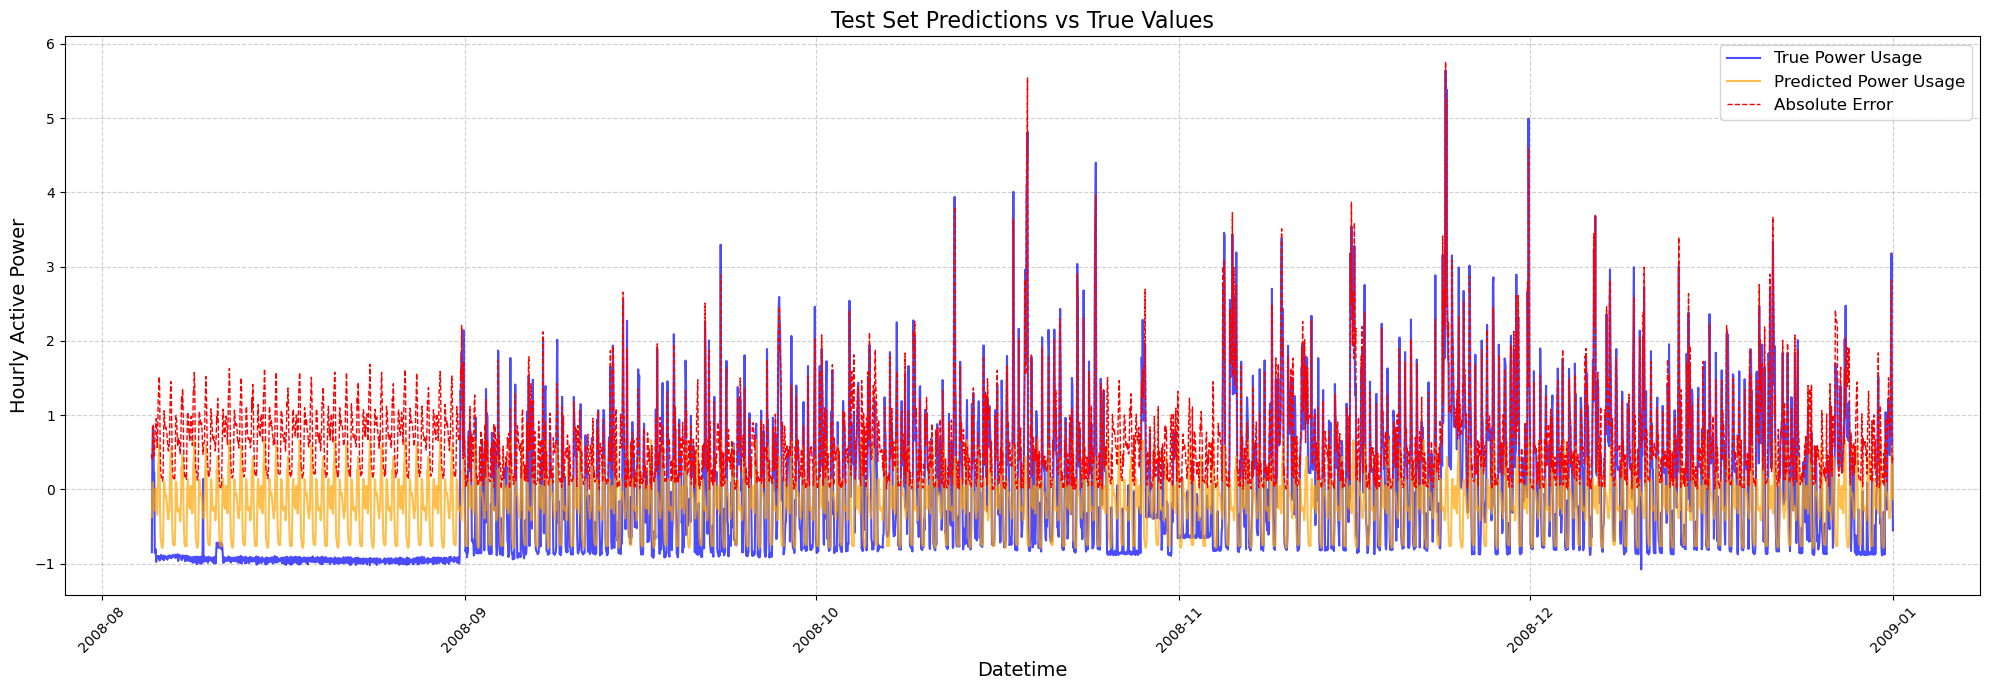

In [10]:
# Extract data for visualization
labels = y_test.values  # True values
predictions = forecast_series.values  # Predicted values
data_index = y_test.index  # Timestamps

graph_prediction(labels, predictions, data_index, plot_error=1)

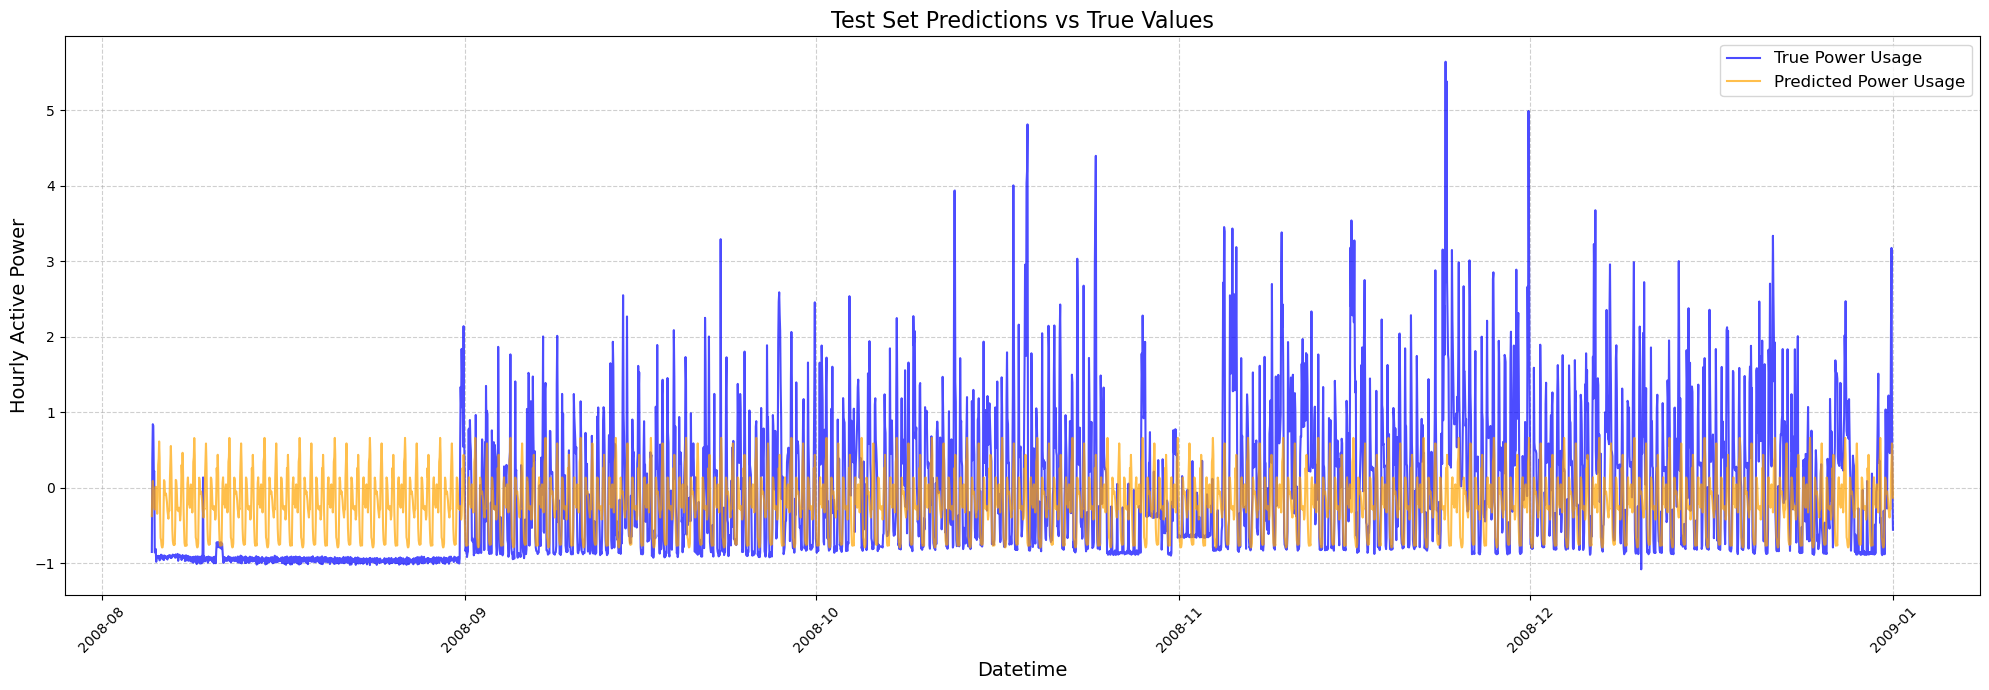

In [11]:
# Extract data for visualization
labels = y_test.values  # True values
predictions = forecast_series.values  # Predicted values
data_index = y_test.index  # Timestamps

graph_prediction(labels, predictions, data_index, plot_error=0)

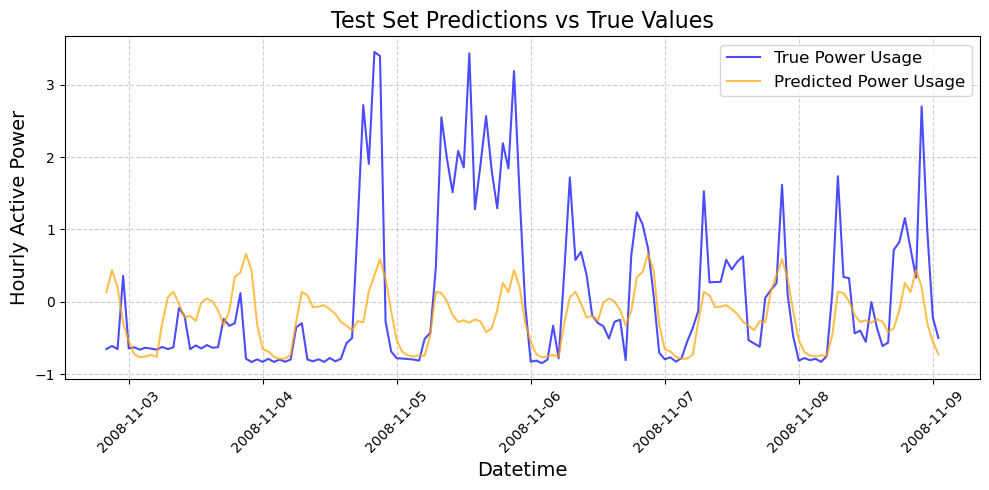

In [ ]:
# # Extract data for visualization
# labels = y_test.values  # True values
# predictions = forecast_series.values  # Predicted values
# data_index = y_test.index  # Timestamps

start = 2150
end = 2300

graph_prediction(labels[start:end], predictions[start:end], data_index[start:end], \
                 plot_error=0, width=10, height=5)

## Data Analysis

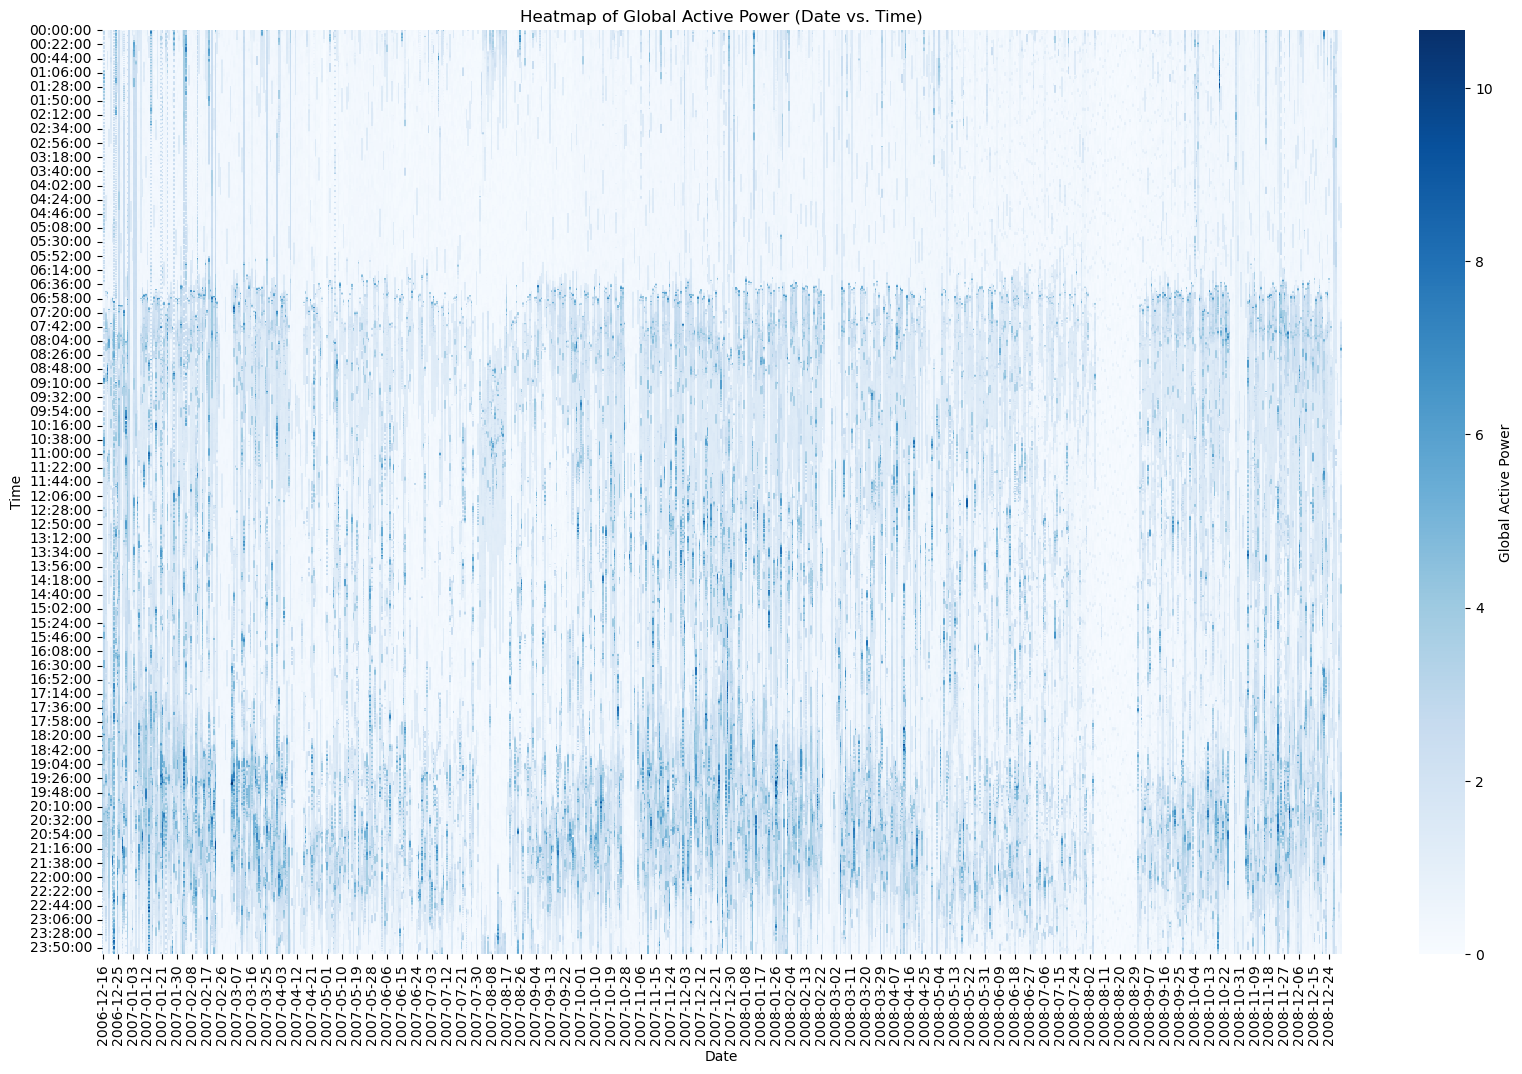

In [12]:
# Load data
df = pd.read_csv('2yrs_data.csv')

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract date and time components
df['Date'] = df['DateTime'].dt.date
df['Time'] = df['DateTime'].dt.time

# Pivot data to create a matrix of time (y-axis) vs. date (x-axis)
heatmap_data = (
    df.pivot_table(index=df['DateTime'].dt.time, 
                   columns=df['DateTime'].dt.date, 
                   values='Global_active_power', 
                   aggfunc='sum')
)

# Impute missing values with 0
heatmap_data = heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(heatmap_data, cmap="Blues", cbar=True, cbar_kws={'label': 'Global Active Power'})
plt.title("Heatmap of Global Active Power (Date vs. Time)")
plt.xlabel("Date")
plt.ylabel("Time")
plt.show()


<Figure size 1200x600 with 0 Axes>

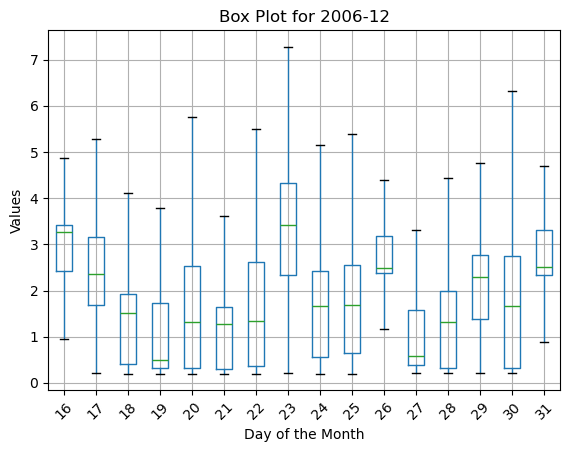

<Figure size 1200x600 with 0 Axes>

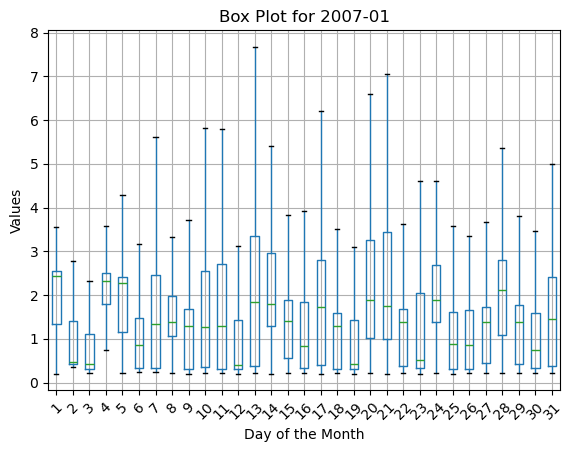

<Figure size 1200x600 with 0 Axes>

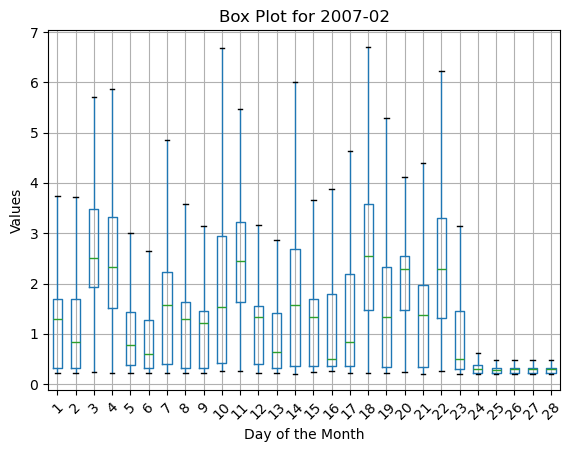

<Figure size 1200x600 with 0 Axes>

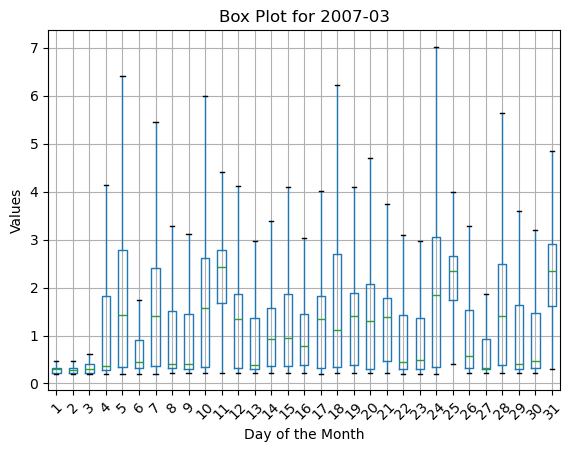

<Figure size 1200x600 with 0 Axes>

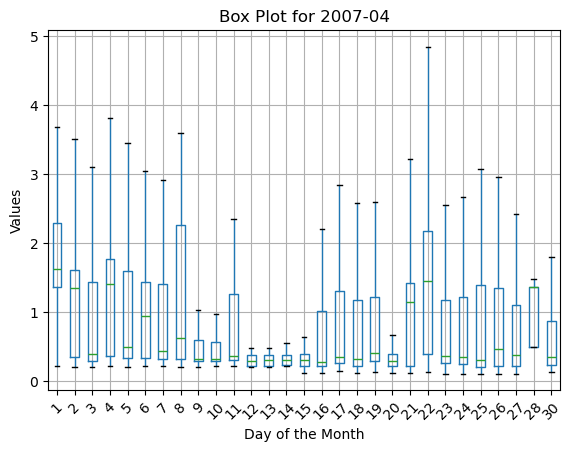

<Figure size 1200x600 with 0 Axes>

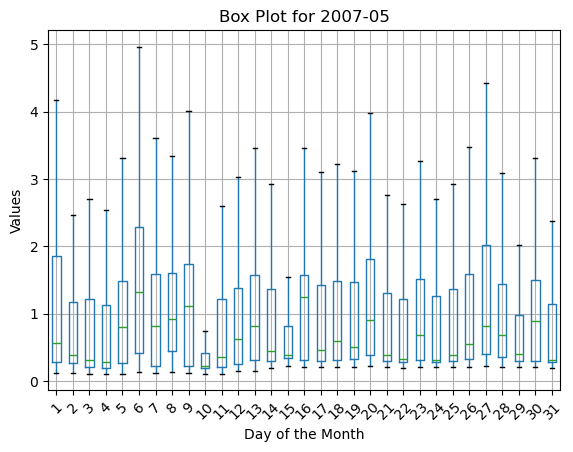

<Figure size 1200x600 with 0 Axes>

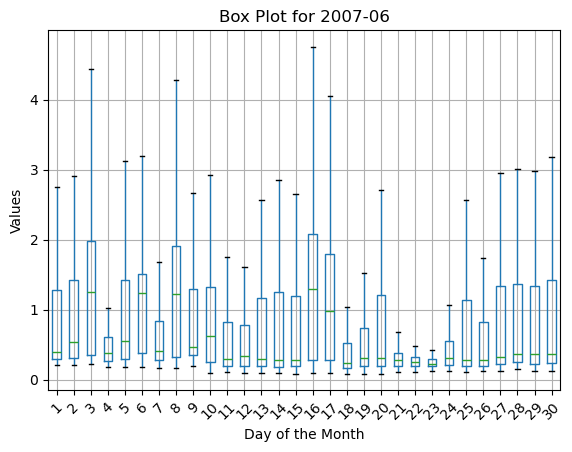

<Figure size 1200x600 with 0 Axes>

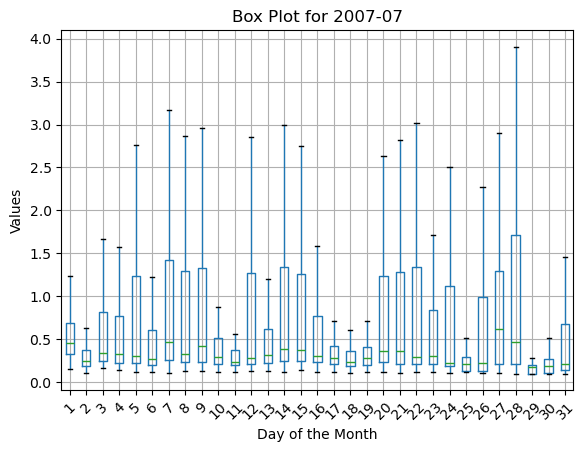

<Figure size 1200x600 with 0 Axes>

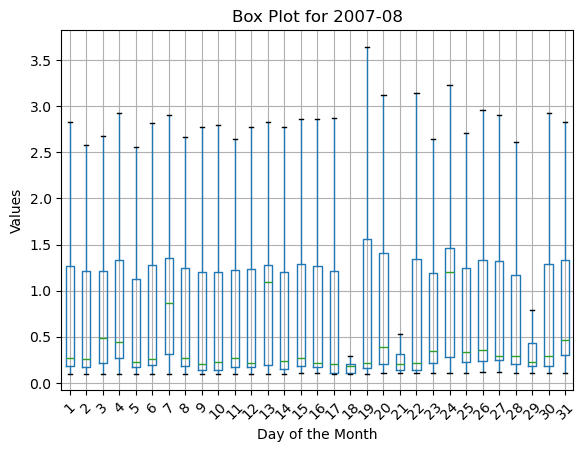

<Figure size 1200x600 with 0 Axes>

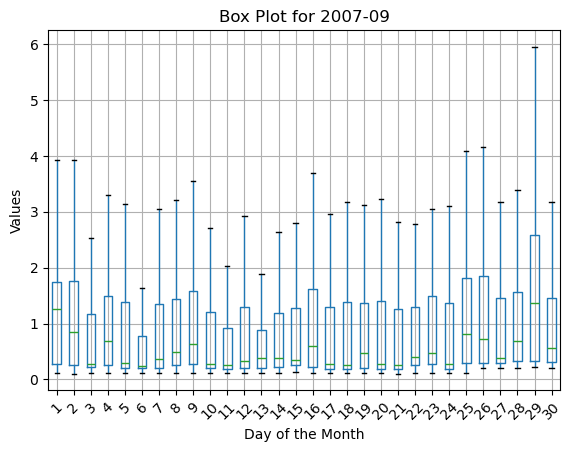

<Figure size 1200x600 with 0 Axes>

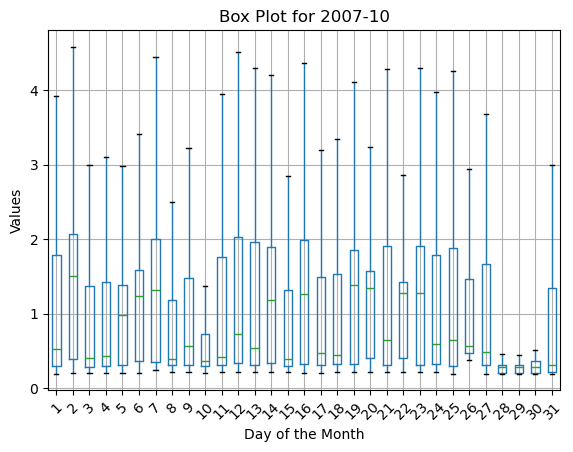

<Figure size 1200x600 with 0 Axes>

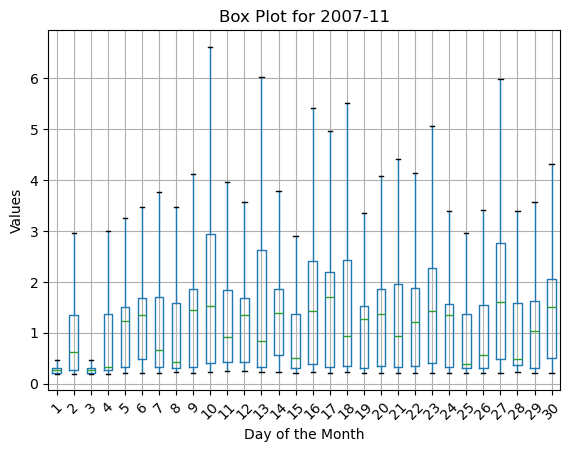

<Figure size 1200x600 with 0 Axes>

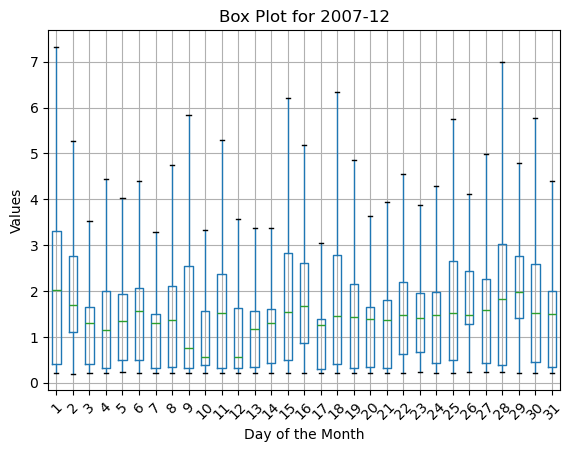

<Figure size 1200x600 with 0 Axes>

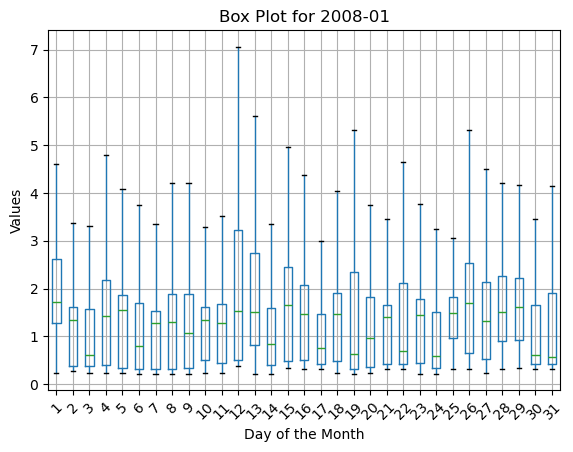

<Figure size 1200x600 with 0 Axes>

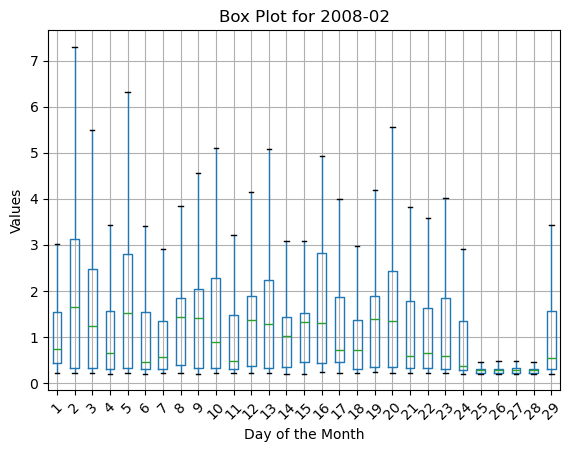

<Figure size 1200x600 with 0 Axes>

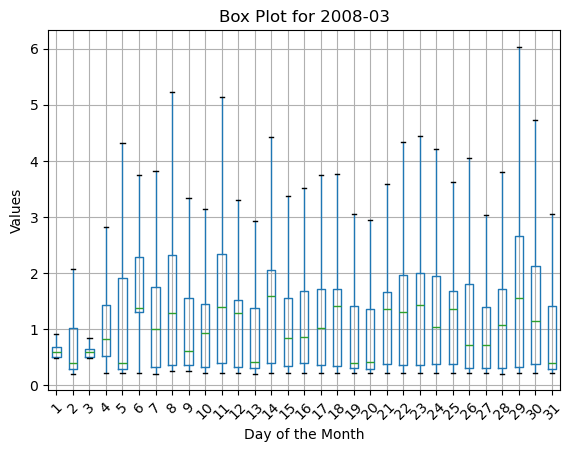

<Figure size 1200x600 with 0 Axes>

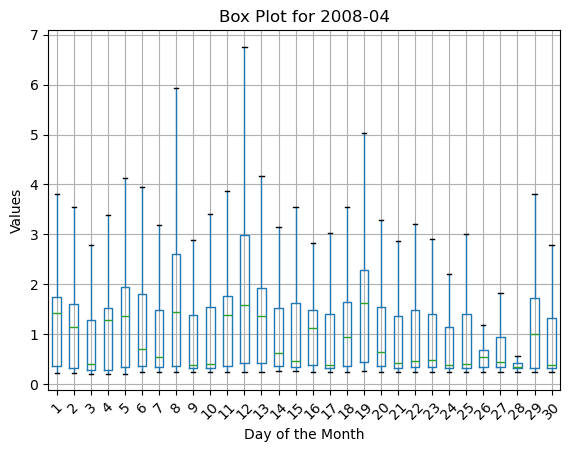

<Figure size 1200x600 with 0 Axes>

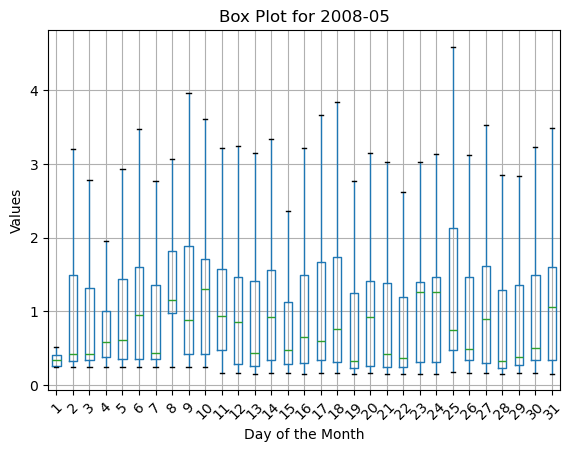

<Figure size 1200x600 with 0 Axes>

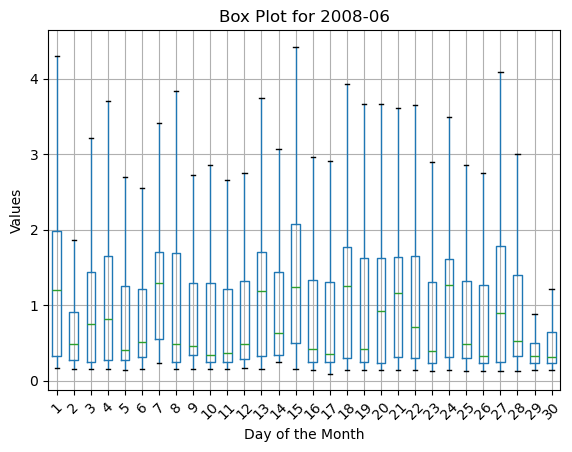

<Figure size 1200x600 with 0 Axes>

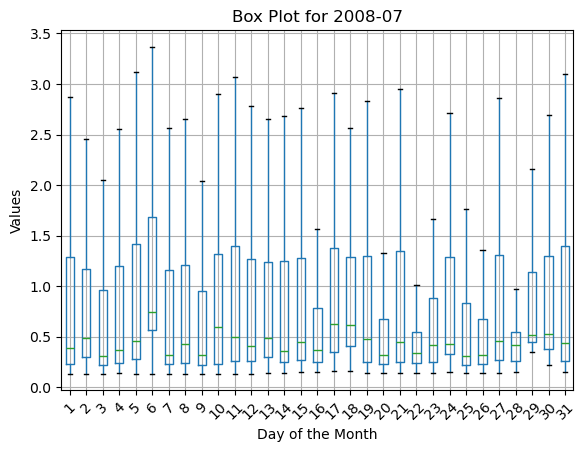

<Figure size 1200x600 with 0 Axes>

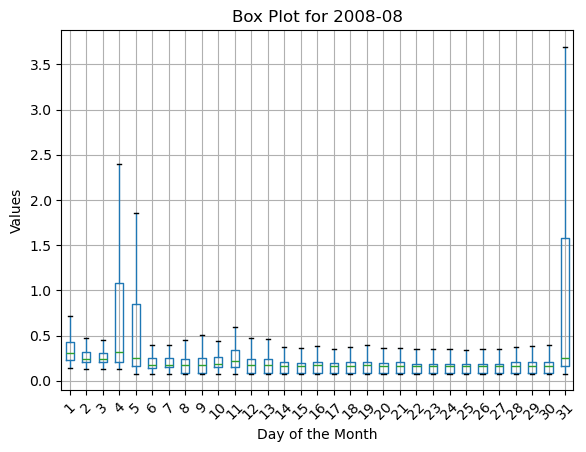

<Figure size 1200x600 with 0 Axes>

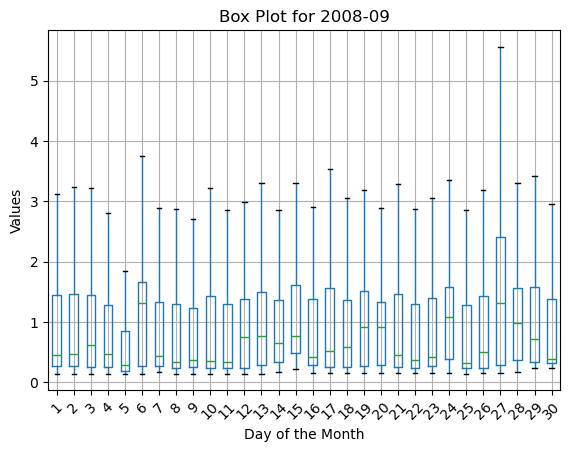

<Figure size 1200x600 with 0 Axes>

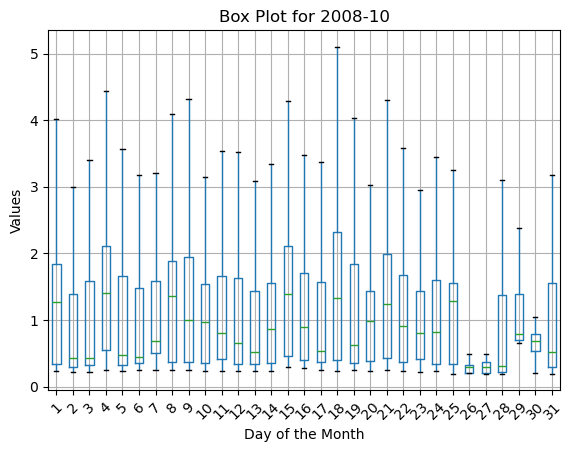

<Figure size 1200x600 with 0 Axes>

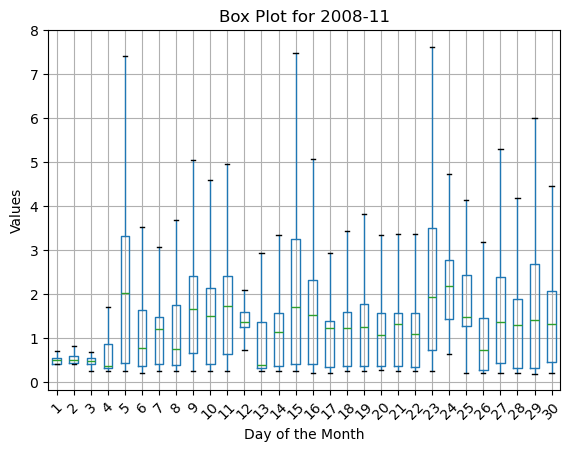

<Figure size 1200x600 with 0 Axes>

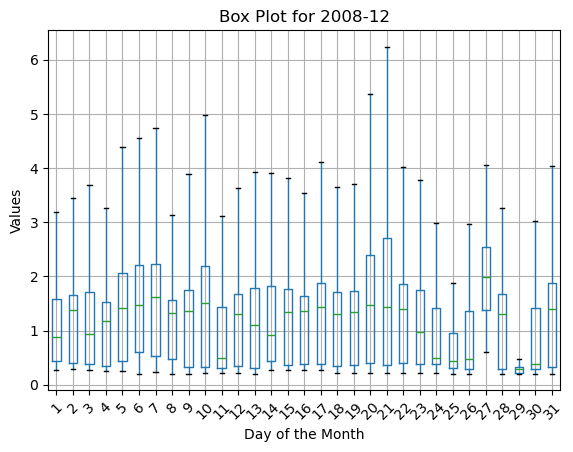

In [ ]:
# Ensure 'Date' is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Extract day and month for grouping
df['Day'] = df['Date'].dt.day
df['MonthYear'] = df['Date'].dt.to_period('M')  # Year-Month grouping

# Iterate through each unique Month-Year and plot
for month_year in df['MonthYear'].unique():
    # Subset the data for the current Month-Year
    monthly_data = df[df['MonthYear'] == month_year]

    # Create the box plot for each day of the month
    plt.figure(figsize=(12, 6))
    monthly_data.boxplot(column='Global_active_power', by='Day', grid=False, showfliers=False)
    plt.title(f'Box Plot for {month_year}')
    plt.suptitle('')
    plt.xlabel('Day of the Month')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()